Zadajte cestu k GPX súboru: C:\Users\david\Desktop\gpx\Devin.gpx
+---------------------------+-------------+
| Štatistika                | Hodnota     |
+===========================+=============+
| Počet bodov               | 3425        |
+---------------------------+-------------+
| Celková vzdialenosť       | 23.28 km    |
+---------------------------+-------------+
| Najnižšia/Najvyššia výška | 125m / 325m |
+---------------------------+-------------+
| Celkové stúpanie          | 1054 m      |
+---------------------------+-------------+
| Celkové klesanie          | 1091 m      |
+---------------------------+-------------+
| Dátum                     | 04.02.2021  |
+---------------------------+-------------+
| Čas začiatku túry         | 05:16:26    |
+---------------------------+-------------+
| Čas konca túry            | 08:45:25    |
+---------------------------+-------------+
| Trvanie túry              | 03:28:59    |
+---------------------------+-------------+
| Priemerná

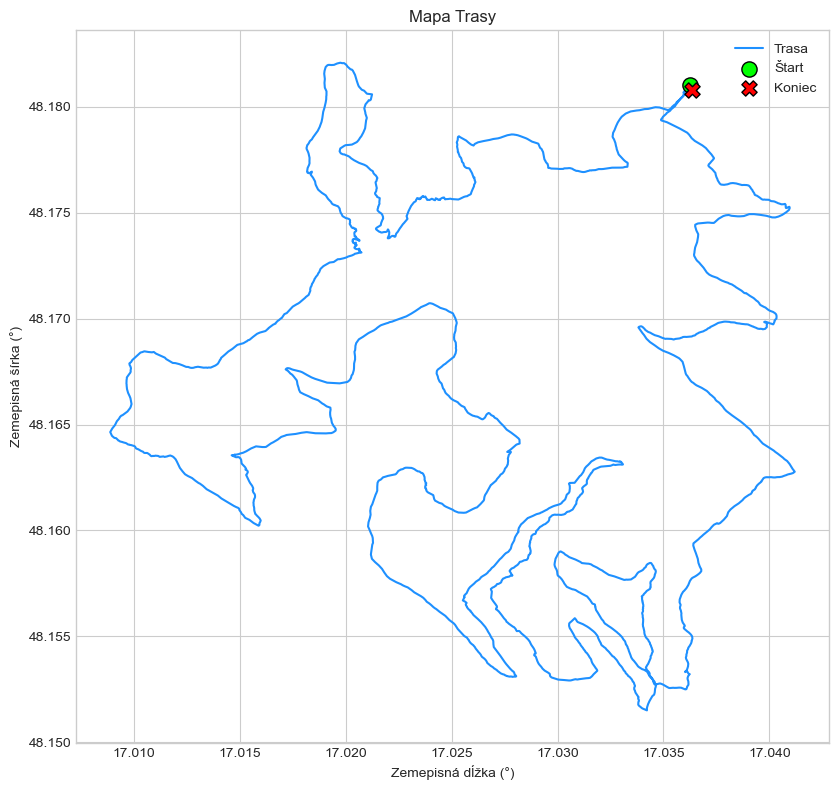

In [50]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.distance import geodesic
from tabulate import tabulate
from datetime import datetime
import numpy as np
import sys

def extract_gpx_data_re(gpx_content):
    pattern_trkpt_tag = r'<trkpt[^>]*>'
    trkpt_tags = re.findall(pattern_trkpt_tag, gpx_content)
    coordinates = []
    pattern_lat = r'lat="([\d.-]+)"'
    pattern_lon = r'lon="([\d.-]+)"'
    for tag in trkpt_tags:
        lat_match = re.search(pattern_lat, tag)
        lon_match = re.search(pattern_lon, tag)
        if lat_match and lon_match:
            lat_val = lat_match.group(1); lon_val = lon_match.group(1)
            if lat_val.strip() != '' and lon_val.strip() != '':
                 coordinates.append((lat_val, lon_val))

    if not coordinates: print("Chyba: regex nenašiel žiadne platné súradnice."); sys.exit(1)

    pattern_elevation = r'<ele>([\d.-]+)</ele>'
    pattern_time = r'<time>(.*?)</time>'
    pattern_cadence = r'<.*?:cad>(\d+)</.*?:cad>'
    pattern_temp = r'<.*?:atemp>([\d.-]+)</.*?:atemp>'

    elevations = re.findall(pattern_elevation, gpx_content)
    time_strings = re.findall(pattern_time, gpx_content)
    cadences = re.findall(pattern_cadence, gpx_content)
    temperatures = re.findall(pattern_temp, gpx_content)
    

    def parse_time_re_components_naive(t_str):
      
        if not t_str or not t_str.strip():
            return None
        t_str = t_str.strip()
        time_pattern = re.compile(
            r"(\d{4})"
            r"-(\d{2})"
            r"-(\d{2})"
            r"T(\d{2})"
            r":(\d{2})"
            r":(\d{2})"
            r"(?:\.(\d+))?"
            r"(?:Z|[+-]\d{2}:?\d{2})?"
        )
        match = time_pattern.match(t_str)
        if not match:
            print(f"Varovanie: Nepodarilo sa spracovať časový reťazec pomocou regex komponentov: '{t_str}'")
            return None
        parts = match.groups()
        
        
        try:
            year, month, day, hour, minute, second = map(int, parts[0:6])
            microsecond = 0
            if parts[6]:
                frac_sec_str = parts[6][:6].ljust(6, '0')
                microsecond = int(frac_sec_str)
            dt_obj = datetime(year, month, day, hour, minute, second, microsecond)
            return dt_obj
        except (ValueError, TypeError, IndexError) as e:
            print(f"Chyba pri vytváraní datetime objektu z regex komponentov pre '{t_str}': {e}")
            return None

    times = [parse_time_re_components_naive(ts) for ts in time_strings]
    

    max_len = len(coordinates)
    data_lists = {'elevations': elevations, 'times': times, 'cadences': cadences, 'temperatures': temperatures}
    aligned_data = {'coordinates': coordinates}
    for key, current_list in data_lists.items():
        current_len = len(current_list)
        if current_len < max_len: current_list.extend([None] * (max_len - current_len))
        elif current_len > max_len: current_list = current_list[:max_len]
        aligned_data[key] = current_list
    return aligned_data

def create_dataframe(extracted_data):

    try:
        data = {
            'Zemepisná šírka': [float(lat) for lat, lon in extracted_data['coordinates']],
            'Zemepisná dĺžka': [float(lon) for lat, lon in extracted_data['coordinates']],
            'Nadmorská výška': pd.to_numeric(extracted_data['elevations'], errors='coerce'),
            'Čas': pd.to_datetime(extracted_data['times'], errors='coerce'),
            'Kadencia': pd.to_numeric(extracted_data['cadences'], errors='coerce'),
            'Teplota': pd.to_numeric(extracted_data['temperatures'], errors='coerce')
        }
        df = pd.DataFrame(data)
        df = df.dropna(subset=['Zemepisná šírka', 'Zemepisná dĺžka']).reset_index(drop=True)
        if df.empty: print("Chyba: Po vytvorení DataFrame nezostali žiadne platné body."); sys.exit(1)
        return df
    except Exception as e:
        print(f"Neznáma chyba pri vytváraní DataFrame: {type(e).__name__}: {e}")
        sys.exit(1)

def calculate_metrics(df):

    if len(df) > 1:
        points = list(zip(df['Zemepisná šírka'], df['Zemepisná dĺžka']))
        distances = [0.0] + [geodesic(points[i-1], points[i]).km if points[i-1] and points[i] else 0.0
                             for i in range(1, len(points))]
        df['Prejdená vzdialenosť'] = np.cumsum(distances)
    else: df['Prejdená vzdialenosť'] = 0.0
    df['ele_interp'] = df['Nadmorská výška'].interpolate()
    if df['ele_interp'].notna().any():
        window_size = 3
        df['ele_smoothed'] = df['ele_interp'].rolling(window=window_size, center=True, min_periods=1).mean().fillna(method='bfill').fillna(method='ffill')
        df['ele_diff_smoothed'] = df['ele_smoothed'].diff().fillna(0)
    else:
        df['ele_smoothed'] = np.nan
        df['ele_diff_smoothed'] = np.nan
    df['Rýchlosť'] = 0.0
    if df['Čas'].notna().any() and len(df.dropna(subset=['Čas'])) > 1:
        df = df.sort_values(by='Čas').reset_index(drop=True)
        df['time_diffs_sec'] = df['Čas'].diff().dt.total_seconds()
        df['dist_diffs_km'] = df['Prejdená vzdialenosť'].diff()
        valid_speed_mask = (df['time_diffs_sec'].notna()) & (df['time_diffs_sec'] > 0) & (df['dist_diffs_km'].notna())
        df.loc[valid_speed_mask, 'Rýchlosť'] = df.loc[valid_speed_mask, 'dist_diffs_km'] / (df.loc[valid_speed_mask, 'time_diffs_sec'] / 3600)
        df['Rýchlosť'] = df['Rýchlosť'].replace([np.inf, -np.inf], 0).fillna(0)
        df.drop(columns=['time_diffs_sec', 'dist_diffs_km'], errors='ignore', inplace=True)
    return df


def generate_statistics(df):

    stats_dict = {"Počet bodov": len(df)}
    total_distance = df['Prejdená vzdialenosť'].iloc[-1] if not df.empty else 0.0
    stats_dict["Celková vzdialenosť"] = f"{total_distance:.2f} km"
    has_elevation = 'ele_smoothed' in df.columns and df['ele_smoothed'].notna().any()
    if has_elevation:
        ele_col_for_minmax = df['ele_interp'] if 'ele_interp' in df.columns and df['ele_interp'].notna().any() else df['Nadmorská výška']
        valid_ele_minmax = ele_col_for_minmax.dropna()
        if not valid_ele_minmax.empty:
            stats_dict["Najnižšia/Najvyššia výška"] = f"{valid_ele_minmax.min():.0f}m / {valid_ele_minmax.max():.0f}m"
        else: stats_dict["Najnižšia/Najvyššia výška"] = "N/A"
        elevation_diffs = df['ele_diff_smoothed'].dropna()
        threshold = 0.0
        climb_diffs = elevation_diffs[elevation_diffs > threshold]; descent_diffs = elevation_diffs[elevation_diffs < -threshold]
        stats_dict["Celkové stúpanie"] = f"{climb_diffs.sum():.0f} m"; stats_dict["Celkové klesanie"] = f"{abs(descent_diffs.sum()):.0f} m"
    else: stats_dict["Najnižšia/Najvyššia výška"] = "N/A"; stats_dict["Celkové stúpanie"] = "N/A"; stats_dict["Celkové klesanie"] = "N/A"
    has_time = df['Čas'].notna().any()
    df_time_valid = df.dropna(subset=['Čas'])
    avg_speed_val = None
    
    if has_time and len(df_time_valid) > 1:
        start_time = df_time_valid['Čas'].iloc[0]; end_time = df_time_valid['Čas'].iloc[-1]
        stats_dict["Dátum"] = start_time.strftime("%d.%m.%Y"); stats_dict["Čas začiatku túry"] = start_time.strftime("%H:%M:%S"); stats_dict["Čas konca túry"] = end_time.strftime("%H:%M:%S");
        total_seconds = (end_time - start_time).total_seconds(); total_seconds = max(0, total_seconds)
        hours=int(total_seconds//3600); minutes=int((total_seconds%3600)//60); seconds=int(total_seconds%60)
        stats_dict["Trvanie túry"] = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        if total_seconds > 0 and total_distance > 0:
            avg_speed_val = total_distance / (total_seconds / 3600); stats_dict["Priemerná rýchlosť"] = f"{avg_speed_val:.2f} km/h"
        else: stats_dict["Priemerná rýchlosť"] = "N/A"
        if 'Rýchlosť' in df.columns and df['Rýchlosť'].notna().any():
            valid_speeds = df['Rýchlosť'][(df['Rýchlosť'] > 0.1) & (df['Rýchlosť'] < 100)]
            if not valid_speeds.empty: stats_dict["Maximálna rýchlosť"] = f"{valid_speeds.quantile(0.99):.2f}"
            else: stats_dict["Maximálna rýchlosť"] = f"{df['Rýchlosť'].max():.2f} km/h"
        else: stats_dict["Maximálna rýchlosť"] = "N/A"
    else: stats_dict["Dátum"]="N/A"; stats_dict["Čas začiatku túry"]="N/A"; stats_dict["Čas konca túry"]="N/A"; stats_dict["Trvanie túry"]="N/A"; stats_dict["Priemerná rýchlosť"]="N/A"; stats_dict["Maximálna rýchlosť"]="N/A"
    stats_dict["Priemerná teplota"] = f"{df['Teplota'].mean():.1f} °C" if 'Teplota' in df.columns and df['Teplota'].notna().any() else "N/A"
    stats_dict["Priemerná kadencia"] = f"{df['Kadencia'].mean():.1f} ot/min" if 'Kadencia' in df.columns and df['Kadencia'].notna().any() else "N/A"
    stats_list = [[k, v] for k, v in stats_dict.items()]
    return stats_list, stats_dict, avg_speed_val

def plot_aggregated_time_series(df_agg, y_col, title, y_label, time_axis_cfg, layout_props):

    if not df_agg.empty and y_col in df_agg.columns and not df_agg[y_col].isna().all():
        try:
            fig = px.line(df_agg, x='Čas_interval', y=y_col, title=title)
            fig.update_layout(yaxis_title=y_label, xaxis=time_axis_cfg, xaxis_title="Čas", **layout_props)
            fig.show()
        except Exception as e: print(f"Chyba pri kreslení grafu '{title}': {e}")
    else: print(f"Graf '{title}' sa nevykreslí (chýbajú dáta).")

def plot_speed_graph(df_agg, avg_speed_val, time_axis_cfg, layout_props):

    fig = None; title = 'Priemerná rýchlosť v čase (10-minútové intervaly)'; y_label = "Priem. Rýchlosť (km/h)"
    if not df_agg.empty and 'Rýchlosť' in df_agg.columns and not df_agg['Rýchlosť'].isna().all():
        try:
            fig = px.line(df_agg, y='Rýchlosť', x='Čas_interval', title=title, labels={'Rýchlosť': 'Priemer (10 min)'})
            fig.update_traces(line=dict(width=2.5), name='Priemer (10 min)', showlegend=True)
        except Exception as e: print(f"Chyba pri kreslení agregovanej rýchlosti: {e}"); fig = None

            
    if fig is not None and avg_speed_val is not None and isinstance(avg_speed_val, (int, float)) and avg_speed_val > 0:
        try:
            fig.add_hline(y=avg_speed_val, line_dash="dash", line_color="red",
                          annotation_text=f"Celkový priemer: {avg_speed_val:.2f} km/h",
                          annotation_position="bottom right")
        except Exception as e: print(f"Chyba pri pridaní čiary priemeru: {e}")
            

    if fig is not None:
        try:
            fig.update_layout(yaxis_title=y_label, xaxis=time_axis_cfg, xaxis_title="Čas", **layout_props);
            fig.show()
        except Exception as e: print(f"Chyba pri finalizácii grafu rýchlosti: {e}")
    else: print("Graf priemernej rýchlosti v čase sa nevykreslí (chýbajú agregované dáta).")

def plot_histogram(df, col, title, x_label, layout_props):

    df_valid = df.dropna(subset=[col])
    if not df_valid.empty:
        try:
            fig = px.histogram(df_valid, x=col, title=title, nbins=20)
            fig.update_layout(xaxis_title=x_label, yaxis_title="Počet bodov", **layout_props)
            fig.show()
        except Exception as e: print(f"Chyba pri kreslení histogramu '{title}': {e}")
    else: print(f"Histogram '{title}' sa nevykreslí (chýbajú dáta v stĺpci '{col}').")

def plot_profile(df, x_col, y_col, title, x_label, y_label, layout_props):

    df_valid = df.dropna(subset=[y_col, x_col])
    if not df_valid.empty:
        try:
            fig = px.line(df_valid, x=x_col, y=y_col, title=title)
            fig.update_layout(xaxis_title=x_label, yaxis_title=y_label, **layout_props)
            fig.show()
        except Exception as e: print(f"Chyba pri kreslení profilu '{title}': {e}")
    else: print(f"Profil '{title}' sa nevykreslí (chýbajú dáta v stĺpcoch '{x_col}' alebo '{y_col}').")

def plot_map(df):

    
    if 'Zemepisná dĺžka' in df.columns and 'Zemepisná šírka' in df.columns and not df.empty:
        try:
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(12, 8));
            plt.plot(df['Zemepisná dĺžka'], df['Zemepisná šírka'], color='dodgerblue', linestyle='-', linewidth=1.5, marker='.', markersize=0, label='Trasa')
            if len(df) > 0:
                plt.scatter(df['Zemepisná dĺžka'].iloc[0], df['Zemepisná šírka'].iloc[0], color='lime', s=120, edgecolors='black', label='Štart', zorder=5, marker='o')
                plt.scatter(df['Zemepisná dĺžka'].iloc[-1], df['Zemepisná šírka'].iloc[-1], color='red', s=120, edgecolors='black', label='Koniec', zorder=5, marker='X')
            plt.xlabel('Zemepisná dĺžka (°)')
            plt.ylabel('Zemepisná šírka (°)')
            plt.title('Mapa Trasy')
            plt.legend()
            try: plt.gca().set_aspect('equal', adjustable='box')
            except ValueError as aspect_e: print(f"Varovanie: Nepodarilo sa nastaviť pomer strán mapy: {aspect_e}")
            plt.tight_layout()
            plt.show()
        except Exception as e: print(f"Chyba pri kreslení mapy trasy: {e}")
    else: print("Mapa trasy sa nevykreslí (chýbajú súradnice).")

if __name__ == "__main__":
    file_path = input("Zadajte cestu k GPX súboru: ")

    try:
        with open(file_path, 'r', encoding='utf-8') as gpx_file:
            gpx_content_main = gpx_file.read()
    except FileNotFoundError: print(f"Chyba: Súbor nebol nájdený na ceste: {file_path}"); sys.exit(1)
    except Exception as e: print(f"Chyba pri načítaní súboru: {e}"); sys.exit(1)

    extracted_data_re = extract_gpx_data_re(gpx_content_main)
    dataframe = create_dataframe(extracted_data_re)
    dataframe = calculate_metrics(dataframe)
    stats_list, stats_dict, avg_speed_val_num = generate_statistics(dataframe)

    
    print(tabulate(stats_list, headers=["Štatistika", "Hodnota"], tablefmt="grid"))
  


    common_layout_props = {'title_x': 0.5, 'font': dict(size=12)}
    has_time = dataframe['Čas'].notna().any()
    has_elevation = 'Nadmorská výška' in dataframe.columns and dataframe['Nadmorská výška'].notna().any()

    avg_speed_val = avg_speed_val_num

    df_aggregated = pd.DataFrame()


    if has_time:
        df_time_valid_agg = dataframe.dropna(subset=['Čas'])
        if not df_time_valid_agg.empty and len(df_time_valid_agg) > 1:
            agg_dict = {}
            cols_for_smoothing = []
            if 'Kadencia' in df_time_valid_agg.columns and df_time_valid_agg['Kadencia'].notna().any():
                agg_dict['Kadencia'] = 'mean'; cols_for_smoothing.append('Kadencia')
            if 'Rýchlosť' in df_time_valid_agg.columns and df_time_valid_agg['Rýchlosť'].notna().any():
                agg_dict['Rýchlosť'] = 'mean'; cols_for_smoothing.append('Rýchlosť')
            if 'Teplota' in df_time_valid_agg.columns and df_time_valid_agg['Teplota'].notna().any():
                agg_dict['Teplota'] = 'mean'; cols_for_smoothing.append('Teplota')

            if agg_dict:
                cols_to_agg = ['Čas'] + list(agg_dict.keys())
                df_agg_base = df_time_valid_agg[cols_to_agg].copy()
                df_agg_base['Čas_interval'] = df_agg_base['Čas'].dt.floor('10min')
                try:
                    df_aggregated = df_agg_base.groupby('Čas_interval').agg(agg_dict).reset_index()
                    if 'Rýchlosť' in df_aggregated.columns: df_aggregated['Rýchlosť'] = df_aggregated['Rýchlosť'].fillna(0)
                    if 'Kadencia' in df_aggregated.columns: df_aggregated['Kadencia'] = df_aggregated['Kadencia'].fillna(0)

                except Exception as agg_e:
                    print(f"Chyba pri agregácii dát pre grafy: {agg_e}");
                    df_aggregated = pd.DataFrame()

    if has_time and not df_aggregated.empty:
        time_axis_config = {'dtick': 600000, 'tickformat': '%H:%M', 'showgrid': True, 'tickangle': -90}


        plot_speed_graph(df_aggregated, avg_speed_val, time_axis_config, common_layout_props)
        plot_aggregated_time_series(df_aggregated, 'Kadencia', 'Priemerná kadencia v čase (10-minútové intervaly)', 'Kadencia (ot/min)', time_axis_config, common_layout_props)
        plot_aggregated_time_series(df_aggregated, 'Teplota', 'Priemerná teplota v čase (10-minútové intervaly)', 'Teplota (°C)', time_axis_config, common_layout_props)
    elif has_time:
         print("Časové grafy (rýchlosť, kadencia, teplota) sa nevykreslia (žiadne dáta na agregáciu).")
    else:
        print("Časové grafy (rýchlosť, kadencia, teplota) sa nevykreslia (chýbajú časové dáta).")

    ele_col_plots = 'ele_interp' if 'ele_interp' in dataframe.columns and dataframe['ele_interp'].notna().any() else 'Nadmorská výška'
    plot_histogram(dataframe, ele_col_plots, 'Rozdelenie nadmorskej výšky', 'Nadmorská výška (m)', common_layout_props)
    plot_profile(dataframe, 'Prejdená vzdialenosť', ele_col_plots, 'Výškový profil (Nadmorská výška vs. Prejdená vzdialenosť)', 'Vzdialenosť (km)', 'Výška (m)', common_layout_props)

    plot_map(dataframe)
